In [31]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

bEdges = np.load('BandEdge.npy').item()
DefTot = np.load('DefectTotalEnergySi.npy').item()
E0 = DefTot['default'][0]['0']
FreyCorr = np.load('FreysoldtCorrectionsSi.npy').item()
ChemPot = np.load('ChemicalReferences.npy').item()
text_def = np.load('LineLabels.npy').item()
colors = np.load('LineColors.npy').item()

In [32]:
def setChemPot(cond, delta={}):
    mu = {}
    mu['Zn'] = cond[0] + ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    mu['Si'] = cond[1] + ChemPot['Si'][0]/ChemPot['Si'][1]['Si']
    mu['N'] = cond[2] + ChemPot['N'][0]/ChemPot['N'][1]['N']
    for ref in ChemPot:
        if len(set(ChemPot[ref][1].keys()) - {'Zn', 'Si', 'N'}) > 1: 
            continue
        if len(ChemPot[ref][1]) == 1:
            for ele in ChemPot[ref][1]:
                if not ele in ['Zn', 'Si', 'N']:
                    if not ele in mu: 
                        mu[ele] = 0
                    mu[ele] = min(mu[ele], ChemPot[ref][0] / ChemPot[ref][1][ele])
        else:
            for ele in ChemPot[ref][1]:
                if not ele in ['Zn', 'Si', 'N']:
                    if not ele in mu: 
                        mu[ele] = 0
                    mu[ele] = min(mu[ele], ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
    return mu

In [33]:
def getPOSCARdiff(defect):
    default = {'Zn':32, 'Si':32, 'N':64}
    n_mu = {}
    for i in DefTot[defect][1]:
        if i in default:
            n_mu[i] = DefTot[defect][1][i] - default[i]
        else: 
            n_mu[i] = DefTot[defect][1][i]
    return n_mu

In [34]:
bEdges['ZnSiN2_VB']

4.009651

In [35]:
def getLine(defect, cond, BandEdges = bEdges, Ef = np.arange(0, bEdges['ZnSiN2_CB']-bEdges['ZnSiN2_VB'],0.0001), charge = ''):
    chem = setChemPot(cond)
    defLoc = deepcopy(DefTot)
    defPar = defLoc[defect]
    n_mu = getPOSCARdiff(defect)
    levels = defPar[0]
    pLevels = {}
    #print levels
    #def_i_l = []
    
    if charge:
        if charge in FreyCorr[defect]:
            levels[charge] += FreyCorr[defect][charge]
        pLevels[charge] = defPar[0][charge] - E0 - sum(n_mu[j] * chem[j] for j in n_mu) + int(charge) * (Ef + BandEdges['ZnSiN2_VB'])
    else: 
        for i in levels:
            # add functionality to get defect levels: 
            # if str(int(i)-1) in levels:
            #    def_i_l += defPar[0][i] - defPar[0][str(int(i)-1)] - bEdges['VB']

            if i in FreyCorr[defect]:
                levels[i] += FreyCorr[defect][i]
            pLevels[i] = defPar[0][i] - E0 - sum(n_mu[j] * chem[j] for j in n_mu) + int(i) * (Ef + BandEdges['ZnSiN2_VB'])
    
    charges = [int(l) for l in pLevels]
    charges.sort()
    intlevels = {defect+' '+str(q)+'/'+str(q+1):round(pLevels[str(q)][0] - pLevels[str(q+1)][0],3) for q in charges[-len(charges):-1]}
    print intlevels
    pDefect = np.minimum.reduce([pLevels[i] for i in pLevels])
    #print (pDefect[0], pDefect[-1])
    return pDefect

In [36]:
from fractions import gcd
def FormEnth(Material):
    mat = ChemPot[Material]
    return (mat[0] - sum(ChemPot[ele][0]/ChemPot[ele][1][ele]* mat[1][ele] for ele in mat[1]))/reduce(gcd,[i for i in mat[1].values()])

In [37]:
Znpoor = [FormEnth('ZnSiN2')- FormEnth('Si3N4')/3,  FormEnth('Si3N4')/3,0]
Sipoor = [0, FormEnth('ZnSiN2'), 0]
Npoor = [0, (FormEnth('Si3N4') -2* FormEnth('ZnSiN2')), 3.0/2.0 * FormEnth('ZnSiN2') - 0.5*FormEnth('Si3N4')]

In [38]:
Npoor

[0, -1.416178491249994, -1.1464052681250028]

In [39]:
def PlotForm(Defects, Condition, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure()
    ax = plt.subplot(111)
    Ef = np.arange(0, BandEdges['ZnSiN2_CB']-BandEdges['ZnSiN2_VB'],0.0001)
    textx = 0.5
    for i in Defects:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects[i]:
            ax.text(Defects[i][0],Defects[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    ax.yaxis.set_ticks_position('both')
    plt.xlim(0, BandEdges['ZnSiN2_CB']-BandEdges['ZnSiN2_VB'])
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    plt.xlabel('Fermi Energy (eV)', fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)

{'Zn_Si -1/0': 0.987, 'Zn_Si -2/-1': 1.74, 'Zn_Si 0/1': 0.417}
{'Se_N 0/1': 4.703, 'Se_N -1/0': 4.773}
{'V_Zn -1/0': 1.054, 'V_Zn -2/-1': 1.594, 'V_Zn 0/1': 0.66}
{'As_Si -1/0': 4.244, 'As_Si 0/1': 4.428}
{'O_N 0/1': 4.704, 'O_N -1/0': 4.689}
{'S_N -1/0': 4.784, 'S_N 0/1': 4.791}


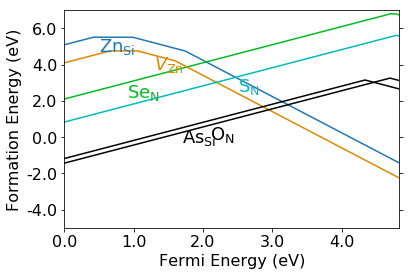

In [40]:
PlotForm({'As_Si':[],'V_Zn':[], 'Zn_Si':[], 'O_N':[], 'S_N':[], 'Se_N':[]},Znpoor,ylimits=[-5,7])

plt.savefig('P_Si.png', bbox_inches='tight', format='png', dpi=300)


{'V_Si -2/-1': 2.753, 'V_Si -1/0': 1.765, 'V_Si -4/-3': 3.783, 'V_Si -3/-2': 3.213}
{'Zn_Si -1/0': 0.987, 'Zn_Si -2/-1': 1.74, 'Zn_Si 0/1': 0.417}
{'V_Zn -1/0': 1.054, 'V_Zn -2/-1': 1.594, 'V_Zn 0/1': 0.66}
{'P_Si -1/0': 5.374, 'P_Si 0/1': 5.105}
{'O_N 0/1': 4.704, 'O_N -1/0': 4.689}
{'S_N -1/0': 4.784, 'S_N 0/1': 4.791}


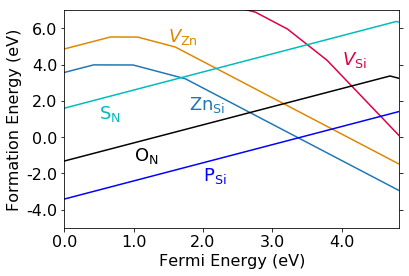

In [41]:
PlotForm({'P_Si':[2.0, -2.4],'V_Zn':[1.5, 5.3], 'Zn_Si':[1.8, 1.5], 'O_N':[1.0, -1.3], 'S_N':[0.5, 1.0], 'V_Si':[4.0, 4.0]},Sipoor,ylimits=[-5,7])

plt.savefig('P_Si.png', bbox_inches='tight', format='png', dpi=300)


{'V_Si -2/-1': 2.753, 'V_Si -1/0': 1.765, 'V_Si -4/-3': 3.783, 'V_Si -3/-2': 3.213}
{'O_N 0/1': 4.704, 'O_N -1/0': 4.689}
{'Zn_Si -1/0': 0.987, 'Zn_Si -2/-1': 1.74, 'Zn_Si 0/1': 0.417}
{'V_Zn -1/0': 1.054, 'V_Zn -2/-1': 1.594, 'V_Zn 0/1': 0.66}
{'P_Si -1/0': 5.374, 'P_Si 0/1': 5.105}
{'S_N -1/0': 4.784, 'S_N 0/1': 4.791}
{'H_i -1/0': 2.814, 'H_i 0/1': 4.193}


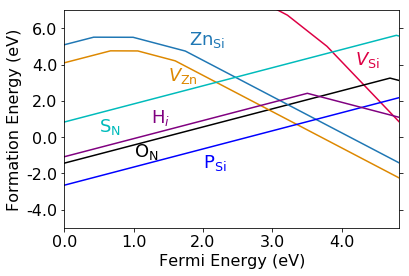

In [45]:
PlotForm({'P_Si':[2.0, -1.7],'V_Zn':[1.5, 3.1], 'Zn_Si':[1.8, 5.1], 'O_N':[1.0, -1.1], 'H_i':[1.25, 0.8], 
          'S_N':[0.5, 0.3], 'V_Si':[4.2, 4.0]},Znpoor,ylimits=[-5,7])

plt.savefig('Si_donors.png', bbox_inches='tight', format='png', dpi=300)


{'V_Si -2/-1': 2.753, 'V_Si -1/0': 1.765, 'V_Si -4/-3': 3.783, 'V_Si -3/-2': 3.213}
{'O_N 0/1': 4.704, 'O_N -1/0': 4.689}
{'V_Zn -1/0': 1.054, 'V_Zn -2/-1': 1.594, 'V_Zn 0/1': 0.66}
{'Zn_Si -1/0': 0.987, 'Zn_Si -2/-1': 1.74, 'Zn_Si 0/1': 0.417}
{'H_i -1/0': 2.814, 'H_i 0/1': 4.193}


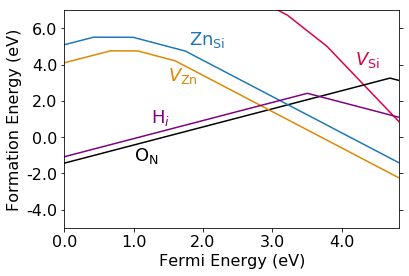

In [26]:
PlotForm({'H_i':[1.25, 0.8],'V_Zn':[1.5, 3.1], 'Zn_Si':[1.8, 5.1], 'O_N':[1.0, -1.3], 'V_Si':[4.2, 4.0]},Znpoor,ylimits=[-5,7])

plt.savefig('Si_native.png', bbox_inches='tight', format='png', dpi=300)


In [27]:
(2.814 + 4.193) / 2

3.5035

In [30]:
bEdges['ZnSiN2_CB'] - bEdges['ZnSiN2_VB'] - 3.5035

1.3275320000000006

In [19]:
FreyCorr

{'Al_Si': {'-1': 0.23862},
 'Al_Zn': {'1': 0.26862},
 'As_N': {},
 'As_Si': {'-1': 0.21862, '1': 0.19862},
 'Ga_Si': {'-1': 0.28862},
 'Ga_Zn': {'1': 0.21362},
 'H_i': {'-1': 0.20862, '1': 0.18062},
 'In_Si': {'-1': 0.21362},
 'In_Zn': {'1': 0.27862},
 'O_N': {'-1': 0.23862, '1': 0.18762},
 'P_N': {'1': 0.19862},
 'P_Si': {'-1': 0.0886203, '1': 0.20862},
 'S_N': {'-1': 0.16862, '1': 0.24862},
 'Se_N': {'-1': 0.17862, '1': 0.19862},
 'V_Si': {'-1': 0.39862, '-2': 1.19448, '-3': 2.34258, '-4': 3.97793},
 'V_Zn': {'-1': 0.27362, '-2': 0.974481, '1': 0.0886203},
 'Zn_Si': {'-1': 0.31862, '-2': 1.03448, '1': 0.0686203},
 'default': {}}

{'P_N 0/1': 1.07}
{'V_Si -2/-1': 2.753, 'V_Si -1/0': 1.765, 'V_Si -4/-3': 3.783, 'V_Si -3/-2': 3.213}


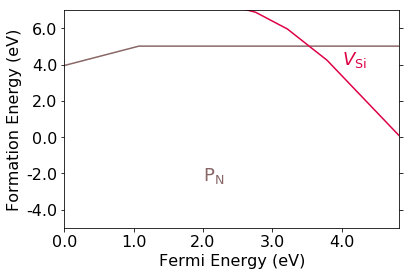

In [13]:
PlotForm({'P_N':[2.0, -2.4],'V_Si':[4.0, 4.0]},Sipoor,ylimits=[-5,7])

In [14]:

Znpoortest = [-0.14,  -2.53,0]
cond=Znpoor

A = getLine('P_Si', cond)
B = getLine('V_Zn', cond)
print[np.argmin(abs(A-B))]
C = getLine('Zn_Si', cond)
print[np.argmin(abs(A-C))]


{'P_Si -1/0': 5.374, 'P_Si 0/1': 5.105}
{'V_Zn -1/0': 1.054, 'V_Zn -2/-1': 1.594, 'V_Zn 0/1': 0.66}
[33544]
{'Zn_Si -1/0': 0.987, 'Zn_Si -2/-1': 1.74, 'Zn_Si 0/1': 0.417}
[36316]


{'H_i -1/0': 2.814, 'H_i 0/1': 4.193}


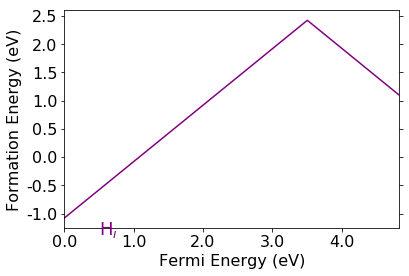

In [15]:
PlotForm({'H_i':[]},Znpoor)

In [13]:
A = getLine('H_i', Znpoor, BandEdges = bEdges, Ef = np.arange(0, bEdges['ZnSiN2_CB']-bEdges['ZnSiN2_VB'],0.0001), charge = '1')
B = getLine('H_i', Znpoor, BandEdges = bEdges, Ef = np.arange(0, bEdges['ZnSiN2_CB']-bEdges['ZnSiN2_VB'],0.0001), charge = '-1')

{}
{}


In [14]:
np.argmin(abs(A-B))

35035

{'V_Zn -1/0': 1.054, 'V_Zn -2/-1': 1.594, 'V_Zn 0/1': 0.66}
{'Al_Zn 0/1': 5.13}
{'In_Si -1/0': 0.738}
{'Zn_Si -1/0': 0.987, 'Zn_Si -2/-1': 1.74, 'Zn_Si 0/1': 0.417}
{'P_Si -1/0': 5.374, 'P_Si 0/1': 5.105}


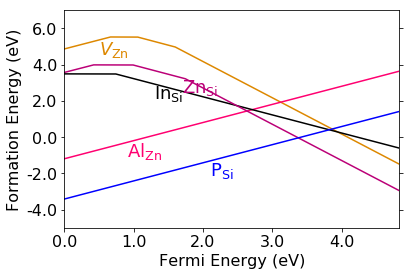

In [15]:
PlotForm({'P_Si':[],'Al_Zn':[], 'In_Si':[], 'Zn_Si':[], 'V_Zn':[]},Sipoor,ylimits=[-5,7])

plt.savefig('Al_Si.png', bbox_inches='tight', format='png', dpi=300)


{'Al_Si -1/0': 0.441}
{'Al_Zn 0/1': 5.13}


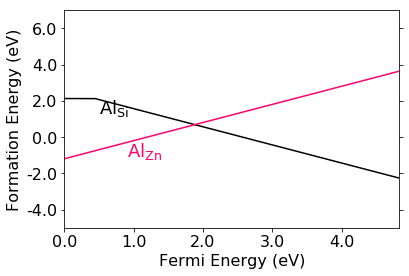

In [56]:
PlotForm({'Al_Zn':[], 'Al_Si':[]},Sipoor,ylimits=[-5,7])

plt.savefig('Al_Si.png', bbox_inches='tight', format='png', dpi=300)


{'V_Zn -1/0': 1.054, 'V_Zn -2/-1': 1.594, 'V_Zn 0/1': 0.66}
{'In_Zn 0/1': 4.516}
{'Zn_Si -1/0': 0.987, 'Zn_Si -2/-1': 1.74, 'Zn_Si 0/1': 0.417}
{'In_Si -1/0': 0.738}


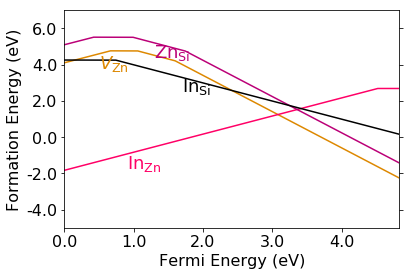

In [26]:
PlotForm({'In_Zn':[], 'In_Si':[], 'Zn_Si':[], 'V_Zn':[]},Znpoor,ylimits=[-5,7])

plt.savefig('In_Si.png', bbox_inches='tight', format='png', dpi=300)


{'Ga_Zn 0/1': 4.889}
{'Ga_Si -1/0': 0.504}
{'Zn_Si -1/0': 0.987, 'Zn_Si -2/-1': 1.74, 'Zn_Si 0/1': 0.417}
{'V_Zn -1/0': 1.054, 'V_Zn -2/-1': 1.594, 'V_Zn 0/1': 0.66}


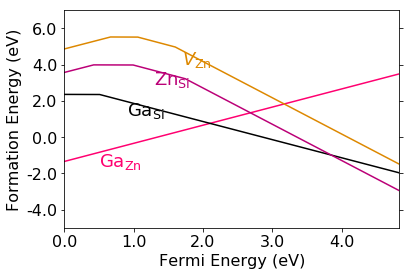

In [27]:
PlotForm({'Ga_Zn':[], 'Ga_Si':[], 'Zn_Si':[], 'V_Zn':[]},Sipoor,ylimits=[-5,7])

plt.savefig('Ga_Si.png', bbox_inches='tight', format='png', dpi=300)


{'P_N 0/1': 1.07}
{'P_Si -1/0': 5.374, 'P_Si 0/1': 5.105}


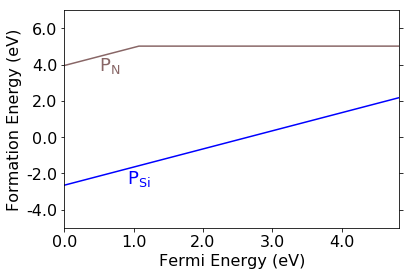

In [28]:
PlotForm({'P_N':[], 'P_Si':[]},Znpoor,ylimits=[-5,7])


In [29]:
plt.plot(A)
plt.plot(B)

NameError: name 'A' is not defined

In [28]:
bEdges

{'GaN25_CB': 5.245438,
 'GaN25_VB': 2.062347,
 'GaN295_CB': 5.447876,
 'GaN295_VB': 1.965016,
 'ZnGeN2_CB': 5.98107,
 'ZnGeN2_VB': 2.791913,
 'ZnSiN2_CB': 8.840683,
 'ZnSiN2_VB': 4.009651,
 'ZnSnN2_CB': 4.613189,
 'ZnSnN2_VB': 3.208647}

In [30]:
def contourdefSi(defect, Ncolors, charge='',add_mu={}):
    defLoc = DefTot[defect]
    n_mu = getPOSCARdiff(defect)
    muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    muSi0 = ChemPot['Si'][0]/ChemPot['Si'][1]['Si']
    x = np.arange(-4.00, 0.0, 1e-2) 
    muZn = x + muZn0
    y = np.arange(-4.00, 0.0, 1e-2) 
    muSi = y + muSi0
    muZn, muSi = np.meshgrid(muZn, muSi)
    muN = (FormEnth('ZnSiN2') - muZn - muSi + muZn0 + muSi0)/2.0 + ChemPot['N'][0]/ChemPot['N'][1]['N']
    mu = {'Zn':muZn, 'Si':muSi, 'N':muN}
    for i in add_mu:
        mu[i] = 0*muZn + add_mu[i]
    for i in mu:
        print mu[i][0][0]
    for ele in DefTot[defect][1]:
        if ele not in mu:
            lrefs = {}
            lmu = {}
            for ref in ChemPot:
                if len(set(ChemPot[ref][1].keys()) - {'Zn', 'Si', 'N'}) > 1: 
                    continue
                if ele in ChemPot[ref][1]:
                    print ChemPot[ref]
                    lrefs[ref] = ref
                    lmu[ref] = np.array(0 * muZn + ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
            if len(lrefs) > 1:
                mumat3 = np.dstack((lmu[i] for i in lmu))
                mu[ele] = np.amin(mumat3, axis=2)
            else:
                mu[ele] = lmu.values()[0]
            
    print n_mu
    if not charge:
        a = sum(n_mu[j] * mu[j] for j in n_mu)
        z = DefTot[defect][0]['0'] - E0 - sum(n_mu[j] * mu[j] for j in n_mu)
        zmin = np.min([z[-1][1],z[-1,-1],z[14][108],z[40][0]])
        zmax = np.max([z[-1][1],z[-1,-1],z[14][108],z[40][0]])
    print zmin, zmax
    N2conv = muSi-muSi0 > (FormEnth('ZnSiN2')-muZn+ muZn0)
    Si3N4conv = muSi-muSi0 < -2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - (muZn-muZn0))
    z = z * N2conv * Si3N4conv + z[50][390]*(2-N2conv-Si3N4conv-(1-N2conv)*(1-Si3N4conv))
    print(z[50][390])
    fig, ax = plt.subplots()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.xlabel('$\Delta\mu_{Zn}$  (eV)', fontsize=18)
    plt.ylabel('$\Delta\mu_{Si}$  (eV)', fontsize=18)
    ax.xaxis.labelpad = 15

    fig.tight_layout()

    cmap = plt.contourf(muZn - muZn0, muSi-muSi0, z, Ncolors)
    ax.fill_between(y, -4, FormEnth('ZnSiN2')-x, facecolor='#ffffff')
    ax.fill_between(y, 0, np.maximum(FormEnth('ZnSiN2')-x,-2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - x)), facecolor='#cc5555')
    ax.set_xlim([-3.75, -0.01])
    ax.set_ylim([-3.75, -0.01])
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.plot(y, FormEnth('ZnSiN2')-x,'k')
    plt.plot(y,np.maximum(FormEnth('ZnSiN2')-x,-2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - x)),'k')
    
    plt.scatter(-0.02 , FormEnth('ZnSiN2')+ 0.02,s=80,color='orange',clip_on=False,zorder=3)
    ax.text(-0.8, FormEnth('ZnSiN2')- 0.2,u'Si-poor',fontdict={'size':18},color='black')

    ax.text(-1.5,-1.1,u'Si$_3$N$_4$',fontdict={'size':18},color='#000000')
    ax.text(-2.5,-3,u'$\Delta\mu_{N} > 0$',fontdict={'size':18},color='#000000')
    
    
    ax.text(1.5,-1.8,r'$E^f (\rm P_{Si})$ (eV)',fontdict={'size':18},color='#000000')

    # Now adding the colorbar
    cbaxes = fig.add_axes([1.05, 0.14, 0.05, 0.6]) 
    cb = plt.colorbar(cmap, cax = cbaxes)
    cb.set_ticks([1.68, 3.32])
    cb.ax.tick_params(labelsize=16)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    #cb.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))



    
    #plt.colorbar(cmap)
    plt.savefig('Contour.eps',bbox_inches='tight', format='eps', dpi=300)
    plt.show() 

In [31]:
Znpoor

[-0.7642701787500017, -2.944718848749998, 0]

-5.2719226
-10.292554671249999
-8.07796109375
[-144.15822104, {'P': 16, 'Zn': 24}]
[-297.47323234, {'P': 12, 'N': 20}]
[-51.69489998, {'P': 8}]
{'P': 1, 'Zn': 0, 'Si': -1, 'N': 0}
4.099719950833251 5.633053284166551
1.8097199508333013


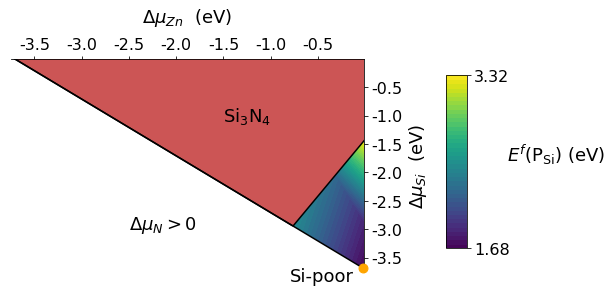

In [32]:
contourdefSi('P_Si',40)


In [33]:
FormEnth('ZnSiN2')

-3.7089890274999995

In [34]:
Znpoor = [FormEnth('ZnSiN2')- FormEnth('Si3N4')/3,  FormEnth('Si3N4')/3,0]
Sipoor = [0, FormEnth('ZnSiN2'), 0]
Npoor = [0, 0, FormEnth('ZnSiN2')/2]

In [35]:
137.21137376 / 2 - 3 * 50.34043737 / 8.0 - 2 * 20.44693316

8.834156546249993

In [36]:
FormEnth('ZnSiN2') - FormEnth('Si3N4')/3

-0.7642701787500017

In [37]:
FormEnth('ZnSiN2') - FormEnth('Si3N4')/4

-1.5004498909375013

In [38]:
def contourdef2(defects, Ncolors, action='add', charge=[],add_mu={}):

    muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    muSi0 = ChemPot['Si'][0]/ChemPot['Si'][1]['Si']
    x = np.arange(-4.00, 0.0, 1e-2) 
    muZn = x + muZn0
    y = np.arange(-4.00, 0.0, 1e-2) 
    muSi = y + muSi0
    muZn, muSi = np.meshgrid(muZn, muSi)
    muN = (FormEnth('ZnSiN2') - muZn - muSi + muZn0 + muSi0)/2.0 + ChemPot['N'][0]/ChemPot['N'][1]['N']
    mu = {'Zn':muZn, 'Si':muSi, 'N':muN}
    Totmu = {}
    for i in add_mu:
        mu[i] = 0*muZn + add_mu[i]
    for i in mu:
        print mu[i][0][0]

    
    for defect in defects:
        defLoc = DefTot[defect]
        n_mu = getPOSCARdiff(defect)
        for ele in DefTot[defect][1]:
            if ele not in mu:
                lrefs = {}
                lmu = {}
                for ref in ChemPot:
                    if len(set(ChemPot[ref][1].keys()) - {'Zn', 'Si', 'N'}) > 1: 
                        continue
                    if ele in ChemPot[ref][1]:
                        print ChemPot[ref]
                        lrefs[ref] = ref
                        lmu[ref] = np.array(0 * muZn + ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
                if len(lrefs) > 1:
                    mumat3 = np.dstack((lmu[i] for i in lmu))
                    mu[ele] = np.amin(mumat3, axis=2)
                else:
                    mu[ele] = lmu.values()[0]

        Totmu[defect] = n_mu
    print Totmu
    if action == 'add':
        z = -sum(sum(Totmu[defiter][j] * mu[j] for j in Totmu[defiter]) for defiter in Totmu)
    elif action == 'subtract':
        z = -sum(Totmu[defects[0]][j] * mu[j] for j in Totmu[defects[0]]) - sum(Totmu[defects[1]][j] * mu[j] for j in Totmu[defects[1]])
    elif action == 'intersect':
        diff = -(sum(Totmu[defects[0]][j] * mu[j] for j in Totmu[defects[0]]) - sum(Totmu[defects[1]][j] * mu[j] for j in Totmu[defects[1]]))
        #print np.amax(diff)
        #print sum(Totmu['O_N'][j] * mu[j] for j in Totmu['O_N'])[0][0]
        #print sum(Totmu['Zn_Ge'][j] * mu[j] for j in Totmu['Zn_Ge'])[0][0]
        #print diff
        #print defects[0]
        #print charge[0]
        diff += (DefTot[defects[0]][0][charge[0]]+FreyCorr[defects[0]][charge[0]] + bEdges['ZnSiN2_VB']*int(charge[0])) - (DefTot[defects[1]][0][charge[1]]+FreyCorr[defects[1]][charge[1]] + bEdges['ZnSiN2_VB']*int(charge[1]))
        z = diff / (float(charge[1]) - float(charge[0]))
    N2conv = muSi-muSi0 > (FormEnth('ZnSiN2')-muZn+ muZn0)
    Si3N4conv = muSi-muSi0 < -2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - (muZn-muZn0))
    z = z * N2conv * Si3N4conv + z[50][390]*(2-N2conv-Si3N4conv-(1-N2conv)*(1-Si3N4conv))
    print(z[50][390])
    fig, ax = plt.subplots()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.xlabel('$\Delta\mu_{Zn}$  (eV)', fontsize=18)
    plt.ylabel('$\Delta\mu_{Si}$  (eV)', fontsize=18)
    ax.xaxis.labelpad = 15

    fig.tight_layout()

    cmap = plt.contourf(muZn - muZn0, muSi-muSi0, z, Ncolors)
    ax.fill_between(y, -4, FormEnth('ZnSiN2')-x, facecolor='#ffffff')
    ax.fill_between(y, 0, np.maximum(FormEnth('ZnSiN2')-x,-2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - x)), facecolor='#cc5555')
    ax.set_xlim([-3.75, -0.01])
    ax.set_ylim([-3.75, -0.01])
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.plot(y, FormEnth('ZnSiN2')-x,'k')
    plt.plot(y,np.maximum(FormEnth('ZnSiN2')-x,-2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - x)),'k')
    
    plt.scatter(-0.02 , FormEnth('ZnSiN2')+ 0.02,s=80,color='orange',clip_on=False,zorder=3)
    ax.text(-0.8, FormEnth('ZnSiN2')- 0.2,u'Si-poor',fontdict={'size':18},color='black')

    ax.text(-1.5,-1.1,u'Si$_3$N$_4$',fontdict={'size':18},color='#000000')
    ax.text(-2.5,-3,u'$\Delta\mu_{N} > 0$',fontdict={'size':18},color='#000000')
    
    
    ax.text(1.5,-1.8,r'$E^f (\rm P_{Si})$ (eV)',fontdict={'size':18},color='#000000')

    # Now adding the colorbar
    cbaxes = fig.add_axes([1.05, 0.14, 0.05, 0.6]) 
    cb = plt.colorbar(cmap, cax = cbaxes)
    #cb.set_ticks([1.68, 3.32])
    cb.ax.tick_params(labelsize=16)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    plt.savefig('Savetemp.png', bbox_inches='tight', format='png', dpi=300)
    return z
    plt.show() 


-5.2719226
-10.292554671249999
-8.07796109375
[-144.15822104, {'P': 16, 'Zn': 24}]
[-297.47323234, {'P': 12, 'N': 20}]
[-51.69489998, {'P': 8}]
{'Zn_Si': {'Zn': 1, 'Si': -1, 'N': 0}, 'P_Si': {'P': 1, 'Zn': 0, 'Si': -1, 'N': 0}}
3.4404398459722345


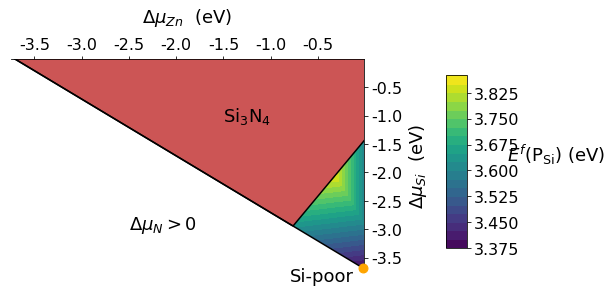

In [39]:
a = contourdef2(['P_Si','Zn_Si'],20,'intersect',charge=['1','-2'])


-5.2719226
-10.292554671249999
-8.07796109375
[-144.15822104, {'P': 16, 'Zn': 24}]
[-297.47323234, {'P': 12, 'N': 20}]
[-51.69489998, {'P': 8}]
{'V_Zn': {'Zn': -1, 'Si': 0, 'N': 0}, 'P_Si': {'P': 1, 'Zn': 0, 'Si': -1, 'N': 0}}
3.791231396388806


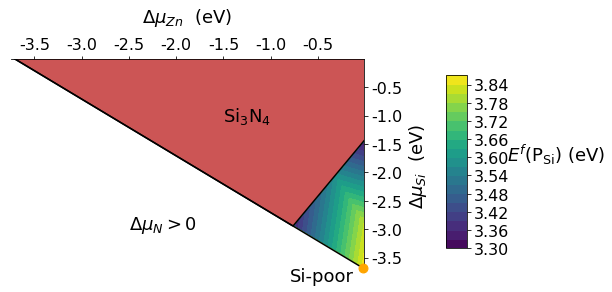

In [40]:
b = contourdef2(['P_Si','V_Zn'],20,'intersect',charge=['1','-2'])


-5.2719226
-10.292554671249999
-8.07796109375
[-144.15822104, {'P': 16, 'Zn': 24}]
[-297.47323234, {'P': 12, 'N': 20}]
[-51.69489998, {'P': 8}]
{'P': 1, 'Zn': 0, 'Si': -1, 'N': 0}
4.099719950833251 5.633053284166551
1.8097199508333013


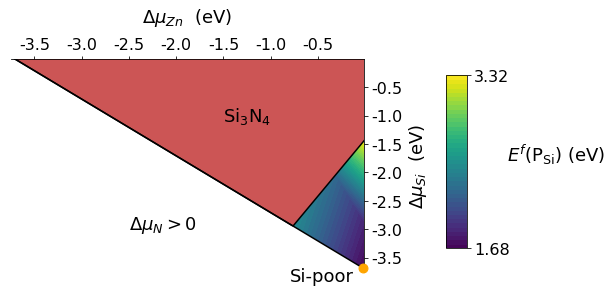

In [41]:
contourdefSi('P_Si',40)


In [42]:
def contourdefmult(defects, Ncolors, action='intersect', charge=[],add_mu={}):

    muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    muSi0 = ChemPot['Si'][0]/ChemPot['Si'][1]['Si']
    x = np.arange(-4.00, 0.0, 1e-2) 
    muZn = x + muZn0
    y = np.arange(-4.00, 0.0, 1e-2) 
    muSi = y + muSi0
    muZn, muSi = np.meshgrid(muZn, muSi)
    muN = (FormEnth('ZnSiN2') - muZn - muSi + muZn0 + muSi0)/2.0 + ChemPot['N'][0]/ChemPot['N'][1]['N']
    mu = {'Zn':muZn, 'Si':muSi, 'N':muN}
    Totmu = {}
    for i in add_mu:
        mu[i] = 0*muZn + add_mu[i]
    for i in mu:
        print mu[i][0][0]

    
    for defect in defects:
        defLoc = DefTot[defect]
        n_mu = getPOSCARdiff(defect)
        for ele in DefTot[defect][1]:
            if ele not in mu:
                lrefs = {}
                lmu = {}
                for ref in ChemPot:
                    if len(set(ChemPot[ref][1].keys()) - {'Zn', 'Si', 'N'}) > 1: 
                        continue
                    if ele in ChemPot[ref][1]:
                        print ChemPot[ref]
                        lrefs[ref] = ref
                        lmu[ref] = np.array(0 * muZn + ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
                if len(lrefs) > 1:
                    mumat3 = np.dstack((lmu[i] for i in lmu))
                    mu[ele] = np.amin(mumat3, axis=2)
                else:
                    mu[ele] = lmu.values()[0]

        Totmu[defect] = n_mu
    print Totmu
    if action == 'intersect':
        diff = -(sum(Totmu[defects[0]][j] * mu[j] for j in Totmu[defects[0]]) - sum(Totmu[defects[1]][j] * mu[j] for j in Totmu[defects[1]]))
        diff2 = -(sum(Totmu[defects[0]][j] * mu[j] for j in Totmu[defects[0]]) - sum(Totmu[defects[2]][j] * mu[j] for j in Totmu[defects[2]]))
        #print np.amax(diff)
        #print sum(Totmu['O_N'][j] * mu[j] for j in Totmu['O_N'])[0][0]
        #print sum(Totmu['Zn_Ge'][j] * mu[j] for j in Totmu['Zn_Ge'])[0][0]
        #print diff
        #print defects[0]
        #print charge[0]
        diff += (DefTot[defects[0]][0][charge[0]]+FreyCorr[defects[0]][charge[0]] + bEdges['ZnSiN2_VB']*int(charge[0])) - (DefTot[defects[1]][0][charge[1]]+FreyCorr[defects[1]][charge[1]] + bEdges['ZnSiN2_VB']*int(charge[1]))
        diff2 += (DefTot[defects[0]][0][charge[0]]+FreyCorr[defects[0]][charge[0]] + bEdges['ZnSiN2_VB']*int(charge[0])) - (DefTot[defects[2]][0][charge[2]]+FreyCorr[defects[2]][charge[2]] + bEdges['ZnSiN2_VB']*int(charge[2]))
        z = diff / (float(charge[1]) - float(charge[0]))
        z2 = diff2 / (float(charge[2]) - float(charge[0]))
        zall = np.dstack((z, z2))
        print zall.shape
        zf = np.amin(zall, axis=2)
    N2conv = muSi-muSi0 > (FormEnth('ZnSiN2')-muZn+ muZn0)
    Si3N4conv = muSi-muSi0 < -2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - (muZn-muZn0))
    zf = zf * N2conv * Si3N4conv + zf[50][390]*(2-N2conv-Si3N4conv-(1-N2conv)*(1-Si3N4conv))
    print(zf[60][390])
    fig, ax = plt.subplots()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.xlabel('$\Delta\mu_{Zn}$  (eV)', fontsize=18)
    plt.ylabel('$\Delta\mu_{Si}$  (eV)', fontsize=18)
    ax.xaxis.labelpad = 15

    fig.tight_layout()

    cmap = plt.contourf(muZn - muZn0, muSi-muSi0, zf, Ncolors)
    ax.fill_between(y, -4, FormEnth('ZnSiN2')-x, facecolor='#ffffff')
    ax.fill_between(y, 0, np.maximum(FormEnth('ZnSiN2')-x,-2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - x)), facecolor='#cc5555')
    ax.set_xlim([-3.75, -0.01])
    ax.set_ylim([-3.75, -0.01])
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.plot(y, FormEnth('ZnSiN2')-x,'k')
    plt.plot(y,np.maximum(FormEnth('ZnSiN2')-x,-2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - x)),'k')
    
    plt.scatter(-0.02 , FormEnth('ZnSiN2')+ 0.02,s=80,color='orange',clip_on=False,zorder=3)
    ax.text(-0.8, FormEnth('ZnSiN2')- 0.2,u'Si-poor',fontdict={'size':18},color='black')

    ax.text(-1.5,-1.1,u'Si$_3$N$_4$',fontdict={'size':18},color='#000000')
    ax.text(-2.5,-3,u'$\Delta\mu_{N} > 0$',fontdict={'size':18},color='#000000')
    
    

    # Now adding the colorbar
    cbaxes = fig.add_axes([1.05, 0.14, 0.05, 0.6]) 
    cb = plt.colorbar(cmap, cax = cbaxes)
    #cb.set_ticks([1.68, 3.32])
    cb.set_ticks([3.33, 3.71])
    ax.text(1.4,-1.85,r'$E_F$ (eV)',fontdict={'size':18},color='#000000')
    cb.ax.tick_params(labelsize=16)

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.savefig('ZnSiN2.png', bbox_inches='tight', format='png', dpi=400)
    #plt.savefig('ZnSiN2.eps', bbox_inches='tight', format='eps', dpi=400)
    return zf
    plt.show() 

-5.2719226
-10.292554671249999
-8.07796109375
[-144.15822104, {'P': 16, 'Zn': 24}]
[-297.47323234, {'P': 12, 'N': 20}]
[-51.69489998, {'P': 8}]
{'V_Zn': {'Zn': -1, 'Si': 0, 'N': 0}, 'Zn_Si': {'Zn': 1, 'Si': -1, 'N': 0}, 'P_Si': {'P': 1, 'Zn': 0, 'Si': -1, 'N': 0}}
(400, 400, 2)
3.468217623750012


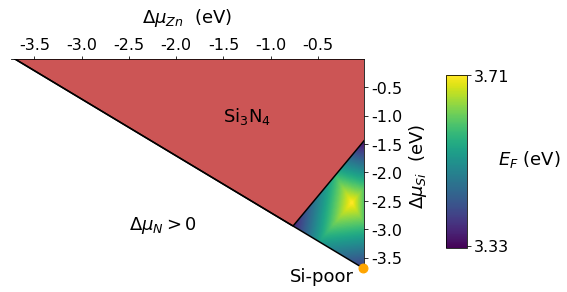

In [43]:
ab = contourdefmult(['P_Si','V_Zn', 'Zn_Si'],200,'intersect',charge=['1','-2','-2'])


{'V_Si -2/-1': 2.753, 'V_Si -1/0': 1.765, 'V_Si -4/-3': 3.783, 'V_Si -3/-2': 3.213}
{'Zn_Si -1/0': 0.987, 'Zn_Si -2/-1': 1.74, 'Zn_Si 0/1': 0.417}
{'V_Zn -1/0': 1.054, 'V_Zn -2/-1': 1.594, 'V_Zn 0/1': 0.66}
{'P_Si -1/0': 5.374, 'P_Si 0/1': 5.105}
{'O_N 0/1': 4.704, 'O_N -1/0': 4.689}
{'S_N -1/0': 4.784, 'S_N 0/1': 4.791}


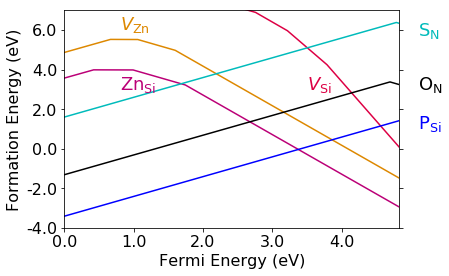

In [44]:
PlotForm({'S_N':[5.1,5.7],
          'P_Si':[5.1, 1.0],
          'O_N':[5.1,3.0],
          'Zn_Si':[0.8,3.0],'V_Zn':[0.8,6], 'V_Si':[3.5, 3.0]},Sipoor,ylimits=[-4,7])

plt.savefig('ntypeSi.eps', bbox_inches='tight', format='eps', dpi=300)
plt.savefig('ntype.png', bbox_inches='tight', format='png', dpi=300)


{'Se_N 0/1': 4.703, 'Se_N -1/0': 4.773}
{'S_N -1/0': 4.784, 'S_N 0/1': 4.791}
{'O_N 0/1': 4.704, 'O_N -1/0': 4.689}
{'As_Si -1/0': 4.244, 'As_Si 0/1': 4.428}
{'P_Si -1/0': 5.374, 'P_Si 0/1': 5.105}


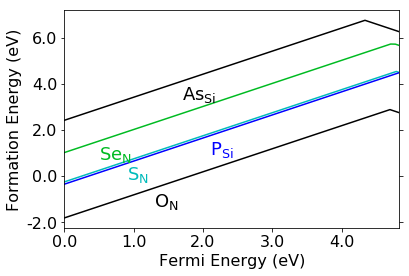

In [45]:
PlotForm({'P_Si':[], 'As_Si':[], 'S_N':[], 'O_N':[], 'Se_N':[]},Npoor)

In [46]:
bEdges['ZnSiN2_CB'] - bEdges['ZnSiN2_VB']


4.831032

-2.2719226
-10.192554671249999
-9.62796109375
101
130
[-144.15822104, {'P': 16, 'Zn': 24}]
[-297.47323234, {'P': 12, 'N': 20}]
[-51.69489998, {'P': 8}]
5759722710504.914


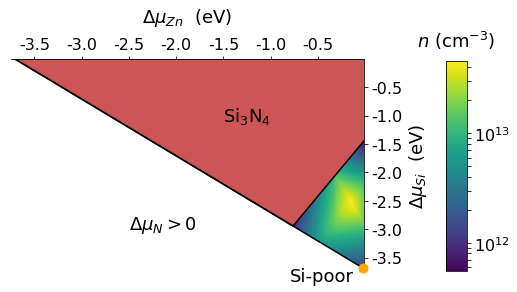

In [49]:
import matplotlib.colors as colors

def contour_n(defects, charge,add_mu={}):
    T = 1000
    me = 0.34712963207175646 * 9.10938e-31
    kb = 1.38064852e-23
    h = 6.62607004e-34
    q = 1.6e-19
    Nc = lambda T: 2 * ((2*np.pi*me*kb*T)/h**2)**(3.0/2.0)/1.0e6
    Eg = bEdges['ZnSiN2_CB']-bEdges['ZnSiN2_VB']
    Ef = np.arange(3.0000,3.7000,0.0001)
    

    Elec = Nc(T)*np.exp((Ef-Eg)*q/kb/T)
    V = 4 / (5.0207e-8 * 5.2388e-8 * 6.26779e-8)

    
    muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    muSi0 = ChemPot['Si'][0]/ChemPot['Si'][1]['Si']
    x = np.arange(-1.00, 0.01, 1e-2) 
    muZn = x + muZn0
    y = np.arange(-3.90, -1.30, 2e-2) 
    muSi = y + muSi0
    muZn, muSi = np.meshgrid(muZn, muSi)
    muN = (FormEnth('ZnSiN2') - muZn - muSi + muZn0 + muSi0)/2.0 + ChemPot['N'][0]/ChemPot['N'][1]['N']
    mu = {'Zn':muZn, 'Si':muSi, 'N':muN}
    Totmu = {}
    for i in add_mu:
        mu[i] = 0*muZn + add_mu[i]
    for i in mu:
        print mu[i][0][0]
        
    EF = 0 * muZn
    print len(x)
    print len(y)

    for defect in defects:
        defLoc = DefTot[defect]
        n_mu = getPOSCARdiff(defect)
        for ele in DefTot[defect][1]:
            if ele not in mu:
                lrefs = {}
                lmu = {}
                for ref in ChemPot:
                    if len(set(ChemPot[ref][1].keys()) - {'Zn', 'Si', 'N'}) > 1: 
                        continue
                    if ele in ChemPot[ref][1]:
                        print ChemPot[ref]
                        lrefs[ref] = ref
                        lmu[ref] = np.array(0 * muZn + ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
                if len(lrefs) > 1:
                    mumat3 = np.dstack((lmu[i] for i in lmu))
                    mu[ele] = np.amin(mumat3, axis=2)
                else:
                    mu[ele] = lmu.values()[0]

        Totmu[defect] = n_mu
    
    Eform = [-(sum(Totmu[defects[p]][j] * mu[j] for j in Totmu[defects[p]])) + (DefTot[defects[p]][0][charge[p]]-DefTot['default'][0]['0']+FreyCorr[defects[p]][charge[p]] + bEdges['ZnSiN2_VB']*int(charge[p])) for p in range(len(charge))]

    defs = np.array([sum(int(charge[i]) * V * np.exp(-(Eform[i]+int(charge[i])*r)*q/kb/T) for i in range(len(charge))) for r in Ef])
    bcde = np.swapaxes(defs,0,2)- np.array(Elec)
    EF = 30000 + np.argmin(abs(np.swapaxes(bcde,0,2)), axis=0)
    nelec = Nc(T)*np.exp((EF/10000.0-Eg)*q/kb/T)

    nelec = Nc(T)*np.exp((EF/10000.0-Eg)*q/kb/T)
    
    N2conv = muSi-muSi0 + 0.02 > (FormEnth('ZnSiN2')-muZn+ muZn0)
    Si3N4conv = muSi-muSi0 -0.02 < -2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - (muZn-muZn0))
    nelec = nelec * N2conv * Si3N4conv + nelec[50][50]*(2-N2conv-Si3N4conv-(1-N2conv)*(1-Si3N4conv))

    print(nelec[50][50])
    
    fig, ax = plt.subplots()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.xlabel('$\Delta\mu_{Zn}$  (eV)', fontsize=18)
    plt.ylabel('$\Delta\mu_{Si}$  (eV)', fontsize=18)
    ax.xaxis.labelpad = 15

    fig.tight_layout()
    n = 50
    A = np.tile(np.logspace(17,20,n),(n,1))
    levels = 10.**np.arange(17,20,4)
        
    cmap = plt.pcolor(muZn - muZn0, muSi-muSi0, nelec,
                      norm=colors.LogNorm(vmin=nelec.min(), vmax=nelec.max()))
    l = np.arange(-4.0, 0, 0.01)
    ax.fill_between(l, -4, FormEnth('ZnSiN2')-l, facecolor='#ffffff')
    ax.fill_between(l, 0, np.maximum(FormEnth('ZnSiN2')-l,-2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - l)), facecolor='#cc5555')
    ax.set_xlim([-3.75, -0.01])
    ax.set_ylim([-3.75, -0.01])
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.plot(l, FormEnth('ZnSiN2')-l,'k')
    plt.plot(l,np.maximum(FormEnth('ZnSiN2')-l,-2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - l)),'k')
    
    plt.scatter(-0.02 , FormEnth('ZnSiN2')+ 0.02,s=80,color='orange',clip_on=False,zorder=3)
    ax.text(-0.8, FormEnth('ZnSiN2')- 0.2,u'Si-poor',fontdict={'size':18},color='black')

    ax.text(-1.5,-1.1,u'Si$_3$N$_4$',fontdict={'size':18},color='#000000')
    ax.text(-2.5,-3,u'$\Delta\mu_{N} > 0$',fontdict={'size':18},color='#000000')


    cbaxes = fig.add_axes([1.05, 0.06, 0.05, 0.73]) 
    cb = plt.colorbar(cmap, cax = cbaxes)
    #cb.set_ticks([-0.31, 0.02])
    #cb.set_label(label=r'E$_{F,comp}$', size=22)
    
    ax.text(0.55,0.2,r'$n$ ($\rm cm^{-3}$)',fontdict={'size':18},color='#000000')

    
    cb.ax.tick_params(labelsize=16)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.savefig('ZnSiN2.png', bbox_inches='tight', format='png', dpi=400)
    #plt.savefig('ZnGeN2.eps', bbox_inches='tight', format='eps', dpi=400)
    plt.show() 
    
    EF = EF * N2conv * Si3N4conv + EF[50][50]*(2-N2conv-Si3N4conv-(1-N2conv)*(1-Si3N4conv))
    return EF

ab = contour_n(['P_Si','V_Zn', 'Zn_Si'],charge=['1','-2','-2'])


In [48]:
bEdges

{'GaN25_CB': 5.245438,
 'GaN25_VB': 2.062347,
 'GaN295_CB': 5.447876,
 'GaN295_VB': 1.965016,
 'ZnGeN2_CB': 5.98107,
 'ZnGeN2_VB': 2.791913,
 'ZnSiN2_CB': 8.840683,
 'ZnSiN2_VB': 4.009651,
 'ZnSnN2_CB': 4.613189,
 'ZnSnN2_VB': 3.208647}

In [34]:
2.53, 0.14

(2.53, 0.14)

In [35]:
np.argmin(a[31]) #antisite

399

In [36]:
np.argmax(b) #vacancy

12799

In [114]:
np.argmin(ab[256]) #both

IndexError: index 256 is out of bounds for axis 0 with size 130

In [ ]:
12799/400

In [93]:
b[256][399] #Npoor

NameError: name 'b' is not defined

In [ ]:
a[31][399] #Sipoor

In [115]:
ab[147][386]

IndexError: index 147 is out of bounds for axis 0 with size 130

In [ ]:
np.argmax(ab[147])

In [119]:

Znpoortest = [-0.14,  -2.53,0]
cond=[-0.13, -2.52, -0.55]

A = getLine('P_Si', cond)
B = getLine('V_Zn', cond)
print[np.argmin(abs(A-B))]
C = getLine('Zn_Si', cond)
print[np.argmin(abs(A-C))]


{'P_Si -1/0': 5.374, 'P_Si 0/1': 5.105}
{'V_Zn -1/0': 1.054, 'V_Zn -2/-1': 1.594, 'V_Zn 0/1': 0.66}
[37054]
{'Zn_Si -1/0': 0.987, 'Zn_Si -2/-1': 1.74, 'Zn_Si 0/1': 0.417}
[37013]


-5.2719226
-10.292554671249999
-8.07796109375
[-233.76077298, {'Si': 8, 'O': 16}]
[-14.02604683, {'O': 2}]
[-22.76121164, {'Zn': 2, 'O': 2}]
{'Zn': 0, 'Si': 0, 'O': 1, 'N': -1}
2.8948281718750195 4.889828171874978
3.23474041624994


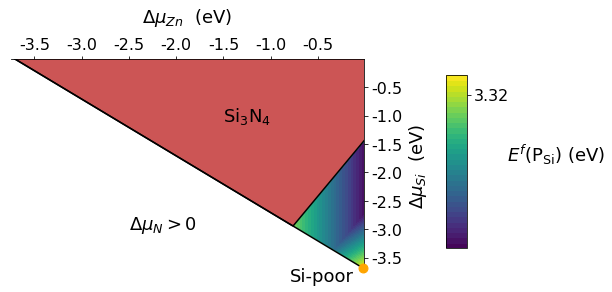

In [120]:
contourdefSi('O_N',40)


In [128]:
y,x = 50,52
a = -1.0 + x/100.0
b = -3.9 + 2*y/100.0
c = -1.8544945137499997 -(a+b)/2.0

V_Zn = getLine('V_Zn', [a,b,c])
Zn_Si = getLine('Zn_Si', [a,b,c])
P_Si = getLine('P_Si', [a,b,c])

#V_Zn = getLine('V_Zn', Gepoor)
#Zn_Ge = getLine('Zn_Ge', Gepoor)
#P_Ge = getLine('P_Ge', Gepoor)

print[a, b, c]

ef = 35049
#Npoor: 30670
#Znpoor1: 29907
#Znpoor2: 28946
#Gepoor: 28549
T = 1000.0
me = 0.34712963207175646 * 9.10938e-31
kb = 1.38064852e-23
h = 6.62607004e-34
q = 1.6e-19
Nc = lambda T: 2 * ((2*np.pi*me*kb*T)/h**2)**(3.0/2.0)/1.0e6
V = 4 / (5.0207e-8 * 5.2388e-8 * 6.26779e-8)


B = V * np.exp(-(P_Si[ef])*q/kb/T)
C = -2*V * np.exp(-(V_Zn[ef])*q/kb/T)
D = -2*V * np.exp(-(Zn_Si[ef])*q/kb/T)

Elec = Nc(T) *np.exp((ef-48310)/10000.0/8.61733e-5/T)

[B + C + D-Elec, Elec]

{'V_Zn -1/0': 1.054, 'V_Zn -2/-1': 1.594, 'V_Zn 0/1': 0.66}
{'Zn_Si -1/0': 0.987, 'Zn_Si -2/-1': 1.74, 'Zn_Si 0/1': 0.417}
{'P_Si -1/0': 5.374, 'P_Si 0/1': 5.105}
[-0.48, -2.9, -0.1644945137499998]


[2.1197462979934484e+16, 6477013589035.251]

In [129]:
[B, Elec]

[1.7012194589197957e+19, 6477013589035.251]

In [ ]:
ab[50,52]

In [ ]:
muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
muSi0 = ChemPot['Si'][0]/ChemPot['Si'][1]['Si']
x = np.arange(-1.00, 0.01, 1e-2) 
muZn = x + muZn0
y = np.arange(-3.90, -1.30, 2e-2) 
muSi = y + muSi0
muZn, muSi = np.meshgrid(muZn, muSi)
muN = (FormEnth('ZnSiN2') - muZn - muSi + muZn0 + muSi0)/2.0 + ChemPot['N'][0]/ChemPot['N'][1]['N']
mu = {'Zn':muZn, 'Si':muSi, 'N':muN}
cmap = plt.pcolor(muZn - muZn0, muSi-muSi0, ab,
             norm=colors.LogNorm(vmin=ab.min(), vmax=ab.max()))


In [ ]:
N2conv = muSi-muSi0 + 0.02 > (FormEnth('ZnSiN2')-muZn+ muZn0)
Si3N4conv = muSi-muSi0 -0.02 < -2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - (muZn-muZn0))


In [ ]:
plt.contourf(muZn - muZn0, muSi-muSi0, Si3N4conv)

In [3]:
FreyCorr

{'Al_Si': {'-1': 0.23862},
 'Al_Zn': {'1': 0.26862},
 'As_N': {},
 'As_Si': {'-1': 0.21862, '1': 0.19862},
 'Ga_Si': {'-1': 0.28862},
 'Ga_Zn': {'1': 0.21362},
 'H_i': {'-1': 0.20862, '1': 0.18062},
 'In_Si': {'-1': 0.21362},
 'In_Zn': {'1': 0.27862},
 'O_N': {'-1': 0.23862, '1': 0.18762},
 'P_N': {'1': 0.19862},
 'P_Si': {'-1': 0.0886203, '1': 0.20862},
 'S_N': {'-1': 0.16862, '1': 0.24862},
 'Se_N': {'-1': 0.17862, '1': 0.19862},
 'V_Si': {'-1': 0.39862, '-2': 1.19448, '-3': 2.34258, '-4': 3.97793},
 'V_Zn': {'-1': 0.27362, '-2': 0.974481, '1': 0.0886203},
 'Zn_Si': {'-1': 0.31862, '-2': 1.03448, '1': 0.0686203},
 'default': {}}